In [1]:
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
import math
import time
from IPython.core.debugger import set_trace



In [2]:
bs = 64
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]



In [3]:
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/gdrive/')


Mounted at /gdrive/


In [5]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = imagenet_stats[0]
        self.imgenet_std = imagenet_stats[1]

    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")

    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(0, 180)),
            transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])

        valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        return train_tfms, valid_tfms

    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.valid_ds = datasets.ImageFolder(root=TEST_PATH, transform=valid_tfms)
        self.train_classes = self.train_ds.classes
        self.valid_classes = self.valid_ds.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes


    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs, shuffle=False, **kwargs))

food = FOOD101()

In [ ]:
food.get_data_extract()

In [7]:
FOOD_PATH = "./food-101"
IMG_PATH = FOOD_PATH+"/images"
META_PATH = FOOD_PATH+"/meta"

VALID_PATH = FOOD_PATH+"/valid"
MODEL_PATH = 'model_data/'

In [8]:
#Explore the dataset. What all files does the dataset entail?


In [9]:
# Text file nomenclature (train.txt, test.txt)
# CLASSLABEL/image

#Classes.txt has all the unique classes

In [10]:
import pandas as pd
from pathlib import Path

In [11]:
image_dir = Path(IMG_PATH)
num_classes = len(os.listdir(IMG_PATH))
print(num_classes)

101


In [12]:

file_paths = list(image_dir.glob(r'**/*.jpg'))
img_classes = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], file_paths))

file_paths = pd.Series(file_paths, name = 'Path').astype(str)
img_classes = pd.Series(img_classes, name ='Food_Label')

df = pd.concat([file_paths, img_classes], axis = 1)


category_samples = []
for category in df['Food_Label'].unique():
    category_slice = df.query("Food_Label == @category")
    category_samples.append(category_slice.sample(1000, random_state=1))
df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [13]:
#Seems like our data is a utpoic distribution of all the food labels
df

,Path,Food_Label
0,food-101/images/takoyaki/114935.jpg,takoyaki
1,food-101/images/foie_gras/1882010.jpg,foie_gras
2,food-101/images/gnocchi/1005096.jpg,gnocchi
3,food-101/images/lobster_roll_sandwich/1616254.jpg,lobster_roll_sandwich
4,food-101/images/pancakes/535614.jpg,pancakes
...,...,...
100995,food-101/images/chocolate_mousse/2423306.jpg,chocolate_mousse
100996,food-101/images/croque_madame/3513520.jpg,croque_madame
100997,food-101/images/risotto/823820.jpg,risotto
100998,food-101/images/huevos_rancheros/115219.jpg,huevos_rancheros


In [14]:
from sklearn.model_selection import train_test_split
items_per_class_train = 750
items_per_class_test = 250

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for class_label in df['Food_Label'].unique():
    # Filter the DataFrame for the current class
    class_data = df[df['Food_Label'] == class_label]

    # Split the current class data into training and testing sets
    class_train, class_test = train_test_split(
        class_data,
        train_size=items_per_class_train,
        test_size=items_per_class_test,
        random_state=42
    )

    # Append the sampled training and testing data to the respective DataFrames
    train_df = pd.concat([train_df, class_train])
    test_df = pd.concat([test_df, class_test])

# Reset the indices of the DataFrames
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [15]:
train_df = train_df.sample(frac=1, random_state=42)
train_df.reset_index(drop=True, inplace=True)

In [16]:
test_df = test_df.sample(frac=1, random_state=42)
test_df.reset_index(drop=True, inplace=True)

In [17]:
train_df

,Path,Food_Label
0,food-101/images/eggs_benedict/1396545.jpg,eggs_benedict
1,food-101/images/pork_chop/3400024.jpg,pork_chop
2,food-101/images/cheesecake/3435169.jpg,cheesecake
3,food-101/images/pork_chop/1518594.jpg,pork_chop
4,food-101/images/cup_cakes/284741.jpg,cup_cakes
...,...,...
75745,food-101/images/prime_rib/2941828.jpg,prime_rib
75746,food-101/images/steak/2832960.jpg,steak
75747,food-101/images/fried_rice/2493844.jpg,fried_rice
75748,food-101/images/foie_gras/2443106.jpg,foie_gras


In [18]:
test_df

,Path,Food_Label
0,food-101/images/sushi/1955181.jpg,sushi
1,food-101/images/french_fries/2239352.jpg,french_fries
2,food-101/images/panna_cotta/3564415.jpg,panna_cotta
3,food-101/images/peking_duck/1016282.jpg,peking_duck
4,food-101/images/escargots/560358.jpg,escargots
...,...,...
25245,food-101/images/ravioli/3114098.jpg,ravioli
25246,food-101/images/french_fries/1781706.jpg,french_fries
25247,food-101/images/lobster_roll_sandwich/1487595.jpg,lobster_roll_sandwich
25248,food-101/images/club_sandwich/3743236.jpg,club_sandwich


#Creating train and test text files consisting of random images from each class

In [19]:
train_paths = list(train_df['Path'])


In [20]:
test_paths = list(test_df['Path'])

In [21]:
train_file = './food-101/train.txt'

with open(train_file, 'w') as file:
  for train in train_paths:
    train_path = Path(train)
    label, img = os.path.split(os.path.split(train_path)[0])[1], os.path.split(train_path)[1]
    file.write(label + '/' + img + '\n')




In [22]:
test_file = './food-101/test.txt'

with open(test_file, 'w') as f:
  for testp in test_paths:
    test_path = Path(testp)
    labels, imgs = os.path.split(os.path.split(test_path)[0])[1], os.path.split(test_path)[1]
    f.write(labels + '/' + imgs + '\n')



# Creating train and test data folders  

In [23]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1])

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [ ]:

TRAIN_PATH = FOOD_PATH+"/train"
print("Creating train data...")
prepare_data(FOOD_PATH+'/train.txt', IMG_PATH, TRAIN_PATH)

In [ ]:
IMG_PATH = FOOD_PATH+"/images"
TEST_PATH = FOOD_PATH+"/test"
print("Creating test data...")
prepare_data(FOOD_PATH+'/test.txt', IMG_PATH, TEST_PATH)

In [26]:
!find food-101/train -type d -or -type f -printf '.' | wc -c

75750


In [27]:
!find food-101/test -type d -or -type f -printf '.' | wc -c

25250


In [28]:
train_ds, valid_ds, classes =  food.get_dataset()
num_classes = len(classes)


#Construct DataLoaders

In [29]:
train_dl, valid_dl = food.get_dls(train_ds, valid_ds, bs=bs, num_workers=2, pin_memory = True)

In [30]:
train_ds

Dataset ImageFolder
    Number of datapoints: 75750
    Root location: ./food-101/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[0.0, 180.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [31]:
img, label = next(iter(train_dl))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")



Image shape: torch.Size([64, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


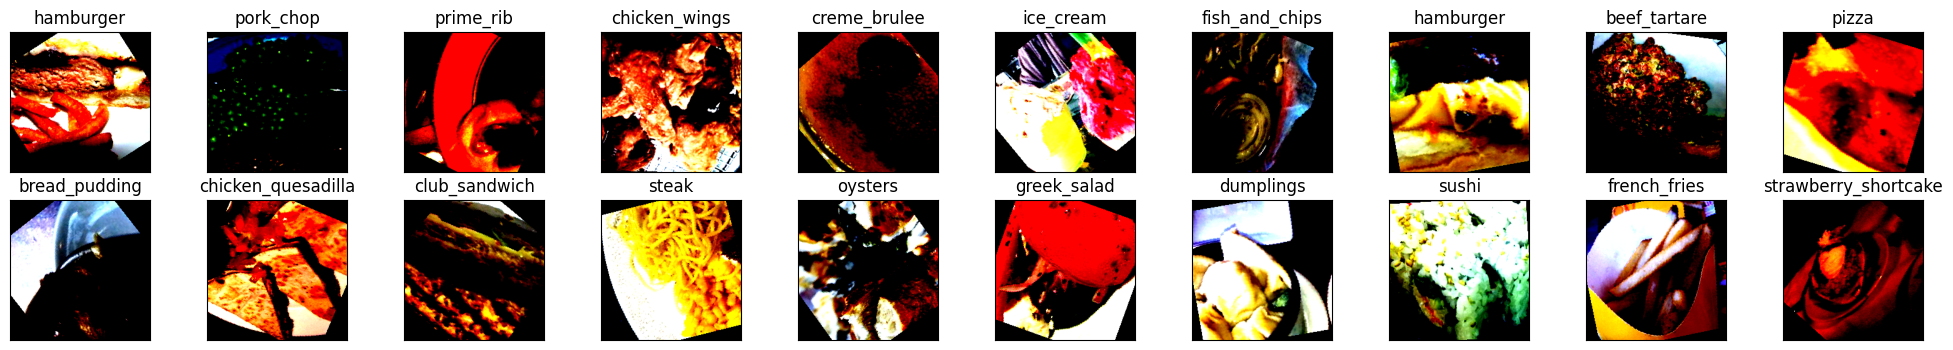

In [32]:
# Visualize some sample training data after Data augmentation

# obtain one batch of training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [46]:
# #specify loss function (categorical cross-entropy)
# criterion = nn.CrossEntropyLoss()

# # specify optimizer (stochastic gradient descent with momentum)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

# # secify learning rate scheduler (if there is no further decrease in loss for next 5 epochs
# # then lower the learning rate by 0.1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)


In [39]:
from torchvision.models.resnet import resnet50
model = models.resnet50(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
               nn.Dropout(0.35),
               nn.Linear(2048, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 101).to(device))

for param in model.fc.parameters():
  param.requires_grad = True


In [41]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

  0%|          | 0/25 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.78E-04


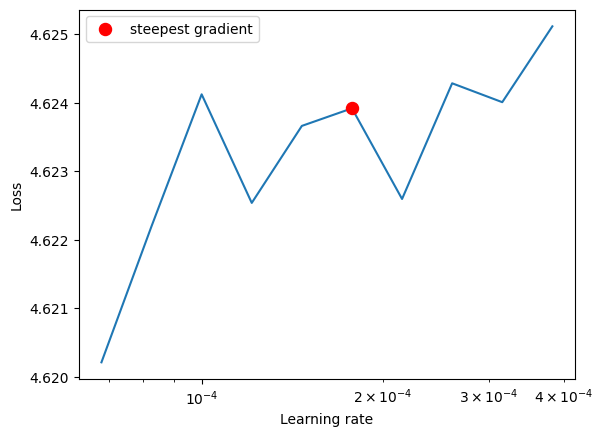

In [42]:
!pip install torch-lr-finder

from torch_lr_finder import LRFinder
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_dl, end_lr=0.001, num_iter=25)
lr_finder.plot()
lr_finder.reset()

In [ ]:
# @title
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
# @title
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
# @title
results = train(model=model,
             train_dataloader=train_dl,
             test_dataloader=valid_dl,
             loss_fn=criterion,
             optimizer=optimizer,
             epochs=1,
             device=device)

save_model(model=model,
          target_dir="./food-101/",
          model_name="resnet50_new.pt")

  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt



In [43]:
from torch.utils.tensorboard import SummaryWriter

cuda = True
epochs = 10
lrs = []
model_name = '/content/resnet50_new.pt'
optimizer = torch.optim.SGD(model.parameters(),lr= 1.78e-04,weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1,patience=1,verbose=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps= epochs * bs)

writer = SummaryWriter() # For Tensorboard
early_stop_count=0
ES_patience=5
best = 0.0
if cuda:
    model.cuda()

for epoch in range(epochs):

    # Training
    model.train()
    correct = 0
    train_loss = 0.0
    tbar = tqdm(train_dl, desc = 'Training', position=0, leave=True)
    for i,(inp,lbl) in enumerate(tbar):
        optimizer.zero_grad()
        if cuda:
            inp,lbl = inp.cuda(),lbl.cuda()
        out = model(inp)
        loss = criterion(out,lbl)
        train_loss += loss
        out = out.argmax(dim=1)
        correct += (out == lbl).sum().item()
        loss.backward()
        optimizer.step()
        tbar.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.5f}, acc: {100.0*correct/((i+1)*train_dl.batch_size):.4f}%")
    train_acc = 100.0*correct/len(train_dl.dataset)
    train_loss /= (len(train_dl.dataset)/bs)

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        val_loss = 0.0
        vbar = tqdm(valid_dl, desc = 'Validation', position=0, leave=True)
        for i,(inp,lbl) in enumerate(vbar):
            if cuda:
                inp,lbl = inp.cuda(),lbl.cuda()
            out = model(inp)
            val_loss += criterion(out,lbl)
            out = out.argmax(dim=1)
            correct += (out == lbl).sum().item()
        val_acc = 100.0*correct/len(valid_dl.dataset)
        val_loss /= (len(valid_dl.dataset)/bs)
    print(f'\nEpoch: {epoch+1}/{epochs}')
    print(f'Train loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Validation loss: {val_loss}, Validation Accuracy: {val_acc}\n')

    scheduler.step(val_loss)
    lrs.append(scheduler.get_last_lr()[0])


    # write to tensorboard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if val_acc>best:
        best=val_acc
        torch.save(model,model_name)
        early_stop_count=0
        print('Accuracy Improved, model saved.\n')
    else:
        early_stop_count+=1

    if early_stop_count==ES_patience:
        print('Early Stopping Initiated...')
        print(f'Best Accuracy achieved: {best:.2f}% at epoch:{epoch-ES_patience}')
        print(f'Model saved as {model_name}')
        break
    writer.flush()
writer.close()

<ipython-input-43-2410dd017909>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tbar = tqdm(train_dl, desc = 'Training', position=0, leave=True)


Training:   0%|          | 0/1184 [00:00<?, ?it/s]

<ipython-input-43-2410dd017909>:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  vbar = tqdm(valid_dl, desc = 'Validation', position=0, leave=True)


Validation:   0%|          | 0/395 [00:00<?, ?it/s]


Epoch: 1/10
Train loss: 4.450528144836426, Train Accuracy: 8.6006600660066
Validation loss: 4.128503799438477, Validation Accuracy: 20.62178217821782



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Accuracy Improved, model saved.



Training:   0%|          | 0/1184 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-2410dd017909>", line 26, in <cell line: 19>
    for i,(inp,lbl) in enumerate(tbar):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 249, in __iter__
    for obj in it:
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1182, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1328, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1284, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/

TypeError: ignored